In [1]:
import sys

In [2]:
sys.path.append('/Users/pradap/Documents/Research/Python-Package/pradap/downsample')

In [63]:
import downsample.core.down_sample

In [57]:
import pandas as pd
import numpy as np
from downsample.core.mur_wrapper_cy import get_str_cols, concat_cols, tokenize_n_rem_stopwords
from downsample.core.mur_wrapper_cy import build_inv_index, sample_pairs

from dask import delayed

def mur_sample(ltable, rtable, sample_size, y_param, stopword_list=[], num_chunks=1):

#    ltbl_str_cols = (get_str_cols)(ltable)


 #   rtable = (delayed)(rtable.sample)(sample_size, replace=False)
 #   rtbl_str_cols = (delayed)(get_str_cols)(rtable)

  #  ltbl_concat_cols = (delayed)(concat_cols)(ltable[ltbl_str_cols])
   # rtbl_concat_cols = (delayed)(concat_cols)(rtable[rtbl_str_cols])


    ltbl = (delayed)(pre_process_ltable)(ltable)
    rtbl = (delayed)(pre_process_rtable)(rtable, sample_size)
    
    
    ret_tokens = (delayed)(tokenize_n_rem_stopwords)(ltbl, rtbl, stopword_list)

    ltokens = ret_tokens[0]
    rtokens = ret_tokens[1]
    
#    ltokens = (delayed)(get_tokens)(ret_tokens, 0)
#    rtokens = (delayed)(get_tokens)(ret_tokens, 1)

    inv_index = (delayed)(build_inv_index)(ltokens)

    #list_indices = range(len(rtokens))


    #rtoken_split = np.array_split(rtokens, num_chunks)
    #indices_split = np.array_split(list_indices, num_chunks)
    
    rtoken_split = (delayed)(get_token_splits)(rtokens, num_chunks)
    indices_split = (delayed)(get_index_splits)(rtokens, num_chunks)
    

    #l_ids = set()
    #r_ids = set()
    result_list = []
    for i in range(num_chunks):
        result = (delayed)(sample_pairs)(rtoken_split[i], indices_split[i], inv_index, y_param)
        result_list.append(result)
    

   # l_ids = (delayed)(sorted)(l_ids)
    #r_ids = (delayed)(sorted)(r_ids)

    #ltbl_sampled = (delayed)(ltable.iloc)[l_ids]
    #rtbl_sampled = (delayed)(rtable.iloc)[r_ids]

    #return (ltbl_sampled, rtbl_sampled)
    #result = (delayed)(post_process)(ltbl_concat_cols, rtbl_concat_cols)
    result = (delayed)(post_process)(result_list, ltable, rtable)
    #res = (delayed)(post_process_2)(rtoken_split, indices_split)
    return result


In [58]:
def pre_process_ltable(ltable):
    ltbl_str_cols = (get_str_cols)(ltable)
    return (concat_cols)(ltable[ltbl_str_cols])

def pre_process_rtable(rtable, sample_size):
    rtable = (rtable.sample)(sample_size, replace=False)
    rtbl_str_cols = (get_str_cols)(rtable)    
    return (concat_cols)(rtable[rtbl_str_cols])
    
    
    
    

In [47]:
def post_process(result_list, ltable, rtable):
    l_ids = set()
    r_ids = set()
    for i in range(len(result_list)):
        result = result_list[i]
        l_ids.update(result[0])
        r_ids.update(result[1])
    l_ids = sorted(l_ids)
    r_ids = sorted(r_ids)
    ltable_sampled = ltable.iloc[l_ids]
    rtable_sampled = rtable.iloc[r_ids]
    return (ltable_sampled, rtable_sampled)
    
        
    

In [23]:
def _post_process(result_list, ltable, rtable):
    return True
def get_tokens(l, index):
    return l[index]
def get_token_splits(tokens, num_chunks):
    return np.array_split(tokens, num_chunks)
def get_index_splits(tokens, num_chunks):
    list_indices = range(len(tokens))
    return np.array_split(list_indices, num_chunks)
def post_process_2(a, b):
    return True



In [6]:
import py_stringsimjoin as ssj

In [7]:
A, B = ssj.load_person_dataset()

In [ ]:
A.head()

In [59]:
result= mur_sample(A, B, 4, 1,  num_chunks=2)

In [60]:
from dask.multiprocessing import get

In [61]:
x = result.compute(get=get)

In [34]:
x[0]

,A.id,A.name,A.birth_year,A.hourly_wage,A.address,A.zipcode
0,a1,Kevin Smith,1989,30.0,"607 From St, San Francisco",94107.0
1,a2,Michael Franklin,1988,27.5,"1652 Stockton St, San Francisco",94122.0
2,a3,William Bridge,1986,32.0,"3131 Webster St, San Francisco",94107.0


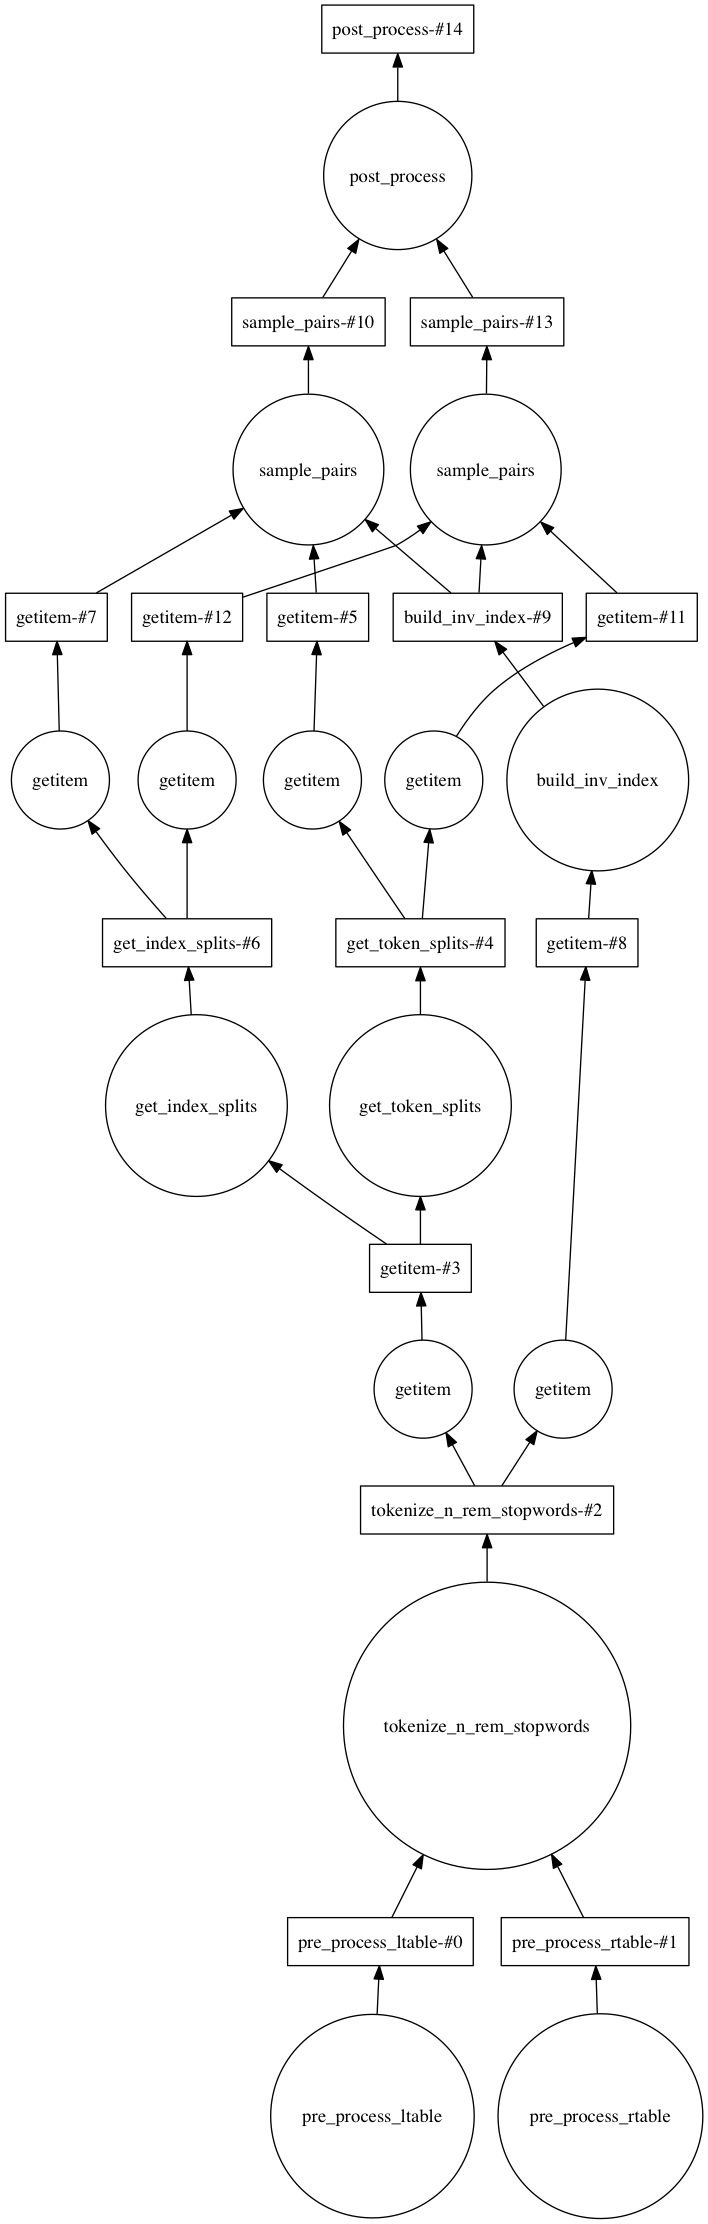

In [62]:
result.visualize(optimize_graph=True)